# Desafío

Zoop ha seleccionado 2 de los visuales creados para formar parte del informe con la narración de datos de la empresa. Se ha definido que se utilizarán los visuales con el **facturamiento por región en 2023** y el de personas **pre-registradas en Zoop Pay**. Refinaremos ambos visuales siguiendo las instrucciones a continuación y la paleta de colores de la e-commerce, alterándolos con la ayuda de ChatGPT:

## Datos anteriores

In [7]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

url_clientes = "https://gist.githubusercontent.com/ahcamachod/d08898e1cc84c7271856e78d9558ca3d/raw/2f7e1fa53711efe6433a5c5ec79948f600591cb9/clientes_zoop.csv"
url_ventas = "https://gist.githubusercontent.com/ahcamachod/966d7162a3c3a2769b8770b35abf1bcc/raw/d79941b3fa46a450f3611589abd8663399c1277b/ventas_zoop.csv"
url_zoop_pay = "https://gist.githubusercontent.com/ahcamachod/ce728231a836a973c0df94a9f03ed871/raw/8db6da43d7cd94fcab937208067d0fceb521b78c/zoop_pay.csv"

clientes = pd.read_csv(url_clientes)
ventas = pd.read_csv(url_ventas)
ventas["fecha"] = pd.to_datetime(ventas["fecha"], format="%Y-%m-%d")
ventas["horario"] = pd.to_datetime(ventas["horario"], format="%H:%M").dt.time

df = pd.merge(ventas, clientes, on="ID_compra", how="inner")
# Reorganizar las columnas en el orden deseado
columnas_ordenadas = [
    "ID_compra",
    "fecha",
    "horario",
    "categoria",
    "precio_unitario",
    "cantidad",
    "envio",
    "metodo_pago",
    "ID_cliente",
    "edad",
    "sexo_biologico",
    "ciudad",
    "estado",
    "region",
    "cashback",
    "nota",
]

# Aplicar el orden de las columnas
df = df[columnas_ordenadas]

clientes = pd.read_csv(url_clientes)
ventas = pd.read_csv(url_ventas)
zoop_pay = pd.read_csv(url_zoop_pay)

# 2. Unir ventas y clientes por 'ID_compra'
df = pd.merge(ventas, clientes, on="ID_compra", how="inner")

# 3. Unir con la base zoop_pay por 'ID_cliente'
df = pd.merge(df, zoop_pay, on="ID_cliente", how="left")

# 4. Renombrar columnas para estandarizar nombres
df = df.rename(
    columns={
        "fecha de la compra": "fecha",
        "hora de la compra": "horario",
        "categoría del producto": "categoria",
        "precio unitario del producto": "precio_unitario",
        "cantidad vendida": "cantidad",
        "método de pago": "metodo_pago",
        "sexo biológico": "sexo_biologico",
        "programa de cashback": "cashback",
    }
)

# 5. Asegurar tipo datetime para la columna 'fecha'
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

# 6. Reordenar las columnas en el orden solicitado
columnas_ordenadas = [
    "ID_compra",
    "fecha",
    "horario",
    "categoria",
    "precio_unitario",
    "cantidad",
    "envio",
    "metodo_pago",
    "ID_cliente",
    "edad",
    "sexo_biologico",
    "ciudad",
    "estado",
    "region",
    "cashback",
    "zoop_pay",
]

df = df[columnas_ordenadas]
df.head()

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear la tabla resumen
metodos_de_pago = df["metodo_pago"].value_counts().reset_index()
metodos_de_pago.columns = ["metodo_pago", "cantidad"]

# 1. Crear una columna de facturación total por compra
df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

# 2. Agrupar por categoría y sumar la facturación
facturacion_categoria = df.groupby("categoria")["facturacion"].sum().sort_values()

# Asegurarse de que la columna 'fecha' es datetime
df["fecha"] = pd.to_datetime(df["fecha"])

# Crear columna con el mes como texto completo
df["mes_nombre"] = df["fecha"].dt.strftime("%B")  # e.g., 'January', 'February', etc.

# Crear columna con el número del mes para ordenar correctamente
df["mes_numero"] = df["fecha"].dt.month

# Calcular la facturación mensual
ventas_mensuales = (
    df.groupby(["mes_numero", "mes_nombre"])["facturacion"].sum().reset_index()
)

# Ordenar por número de mes
ventas_mensuales = ventas_mensuales.sort_values("mes_numero")

# Diccionario de traducción de meses
meses = {
    "January": "Ene",
    "February": "Feb",
    "March": "Mar",
    "April": "Abr",
    "May": "May",
    "June": "Jun",
    "July": "Jul",
    "August": "Ago",
    "September": "Sep",
    "October": "Oct",
    "November": "Nov",
    "December": "Dic",
}

# Aplicar traducción
ventas_mensuales["mes"] = ventas_mensuales["mes_nombre"].map(meses)

# 2. Crear columna de trimestre (formato 'T1', 'T2', etc.)
df["trimestre"] = df["fecha"].dt.to_period("Q").astype(str).str.replace("2023Q", "T")

# 3. Agrupar por trimestre y método de pago, sumando facturación
ventas_trimestre = (
    df.groupby(["trimestre", "metodo_pago"])["facturacion"].sum().unstack(fill_value=0)
)

# Filtrar solo las 3 categorías deseadas
categorias_interes = ["Papelería y oficina", "Libros", "Alimentos y bebidas"]
df_filtrado = df[df["categoria"].isin(categorias_interes)]

# Agrupar por trimestre y categoría, sumando la facturación
ventas_categoria = (
    df_filtrado.groupby(["trimestre", "categoria"])["facturacion"]
    .sum()
    .unstack(fill_value=0)
)

ventas_region = (
    df.groupby("region", as_index=False)["facturacion"]
    .sum()
    .sort_values(
        "facturacion", ascending=True
    )  # orden ascendente para barras horizontales
)

df_filtrado = df[df["estado"].isin(["Estado de México", "Puebla"])]

# 2. Agrupar por estado y sexo biológico, contar cantidad
publico_estado_sexo = (
    df_filtrado.groupby(["estado", "sexo_biologico"])
    .size()
    .reset_index(name="cantidad")
)

# Adicionamos los colores al proyecto
ROJO_1, ROJO_2, ROJO_3 = "#e23155", "#cc2c4e", "#b32742"
AZUL_1, AZUL_2, AZUL_3 = "#203f75", "#1c3867", "#19325b"
BLANCO, GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = (
    "#ffffff",
    "#ebebeb",
    "#d9d9d9",
    "#cccccc",
    "#555655",
    "#231f20",
)
AQUA_1, AQUA_2, AQUA_3 = "#addcd4", "#9fccc5", "#96bfb9"

## Desafío 1:

Construye y ejecuta un prompt en ChatGPT para refinar el visual que presenta el facturamiento de las ventas por región. Las instrucciones para el refinamiento son las siguientes:

- Fondo de la figura y del área del gráfico en el color GRIS_1
- Color de las columnas en AQUA_1 (si deseas destacar solo una, puedes recurrir a AQUA_3, por ejemplo)
- Tamaño de la figura de (16,9)
- Cambia el título de la figura a un tamaño de 18 y color GRIS_5, ajusta las etiquetas y rótulos del eje x e y, cuando existan, a un tamaño 12 y color AZUL_1
- Elimina el máximo de bordes posible y ajusta los datos para que se presenten en las barras en orden de millones, con color AZUL_1 y tamaño 12

**Observación 1:** Todas las variables que representan los colores en las instrucciones están en una celda en la pestaña Paleta de Colores dentro del notebook Desafíos de la Clase 04.

**Observación 2:** Es probable que al ejecutar los prompts, ChatGPT sugiera colores para las variables y modificaciones en los códigos que llaman al DataFrame deseado. Presta mucha atención para eliminar la nueva definición de colores y ajustar el DataFrame según lo que has hecho en actividades anteriores.

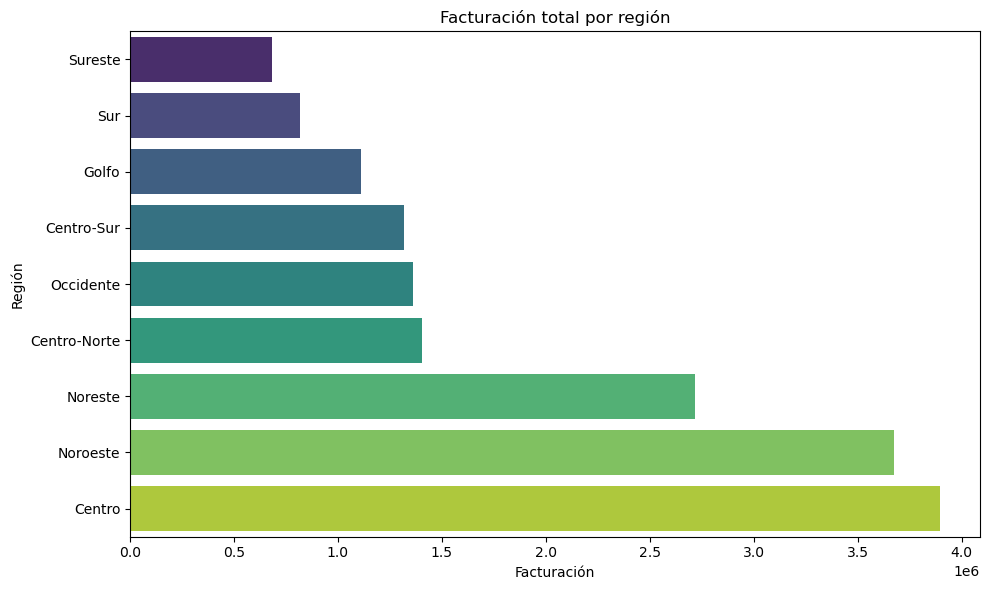

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calcular la facturación por fila
df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

# 2. Agrupar por región y sumar la facturación
ventas_region = (
    df.groupby("region", as_index=False)["facturacion"]
    .sum()
    .sort_values(
        "facturacion", ascending=True
    )  # orden ascendente para barras horizontales
)

# 3. Visualización: barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(data=ventas_region, x="facturacion", y="region", palette="viridis")

plt.title("Facturación total por región")
plt.xlabel("Facturación")
plt.ylabel("Región")
plt.tight_layout()
plt.show()

### Prompt

Ahora vamos a refinar el gráfico de facturación total por región. Anteriormente teníamos esto:
```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calcular la facturación por fila
df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

# 2. Agrupar por región y sumar la facturación
ventas_region = (
    df.groupby("region", as_index=False)["facturacion"]
    .sum()
    .sort_values(
        "facturacion", ascending=True
    )  # orden ascendente para barras horizontales
)

# 3. Visualización: barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(data=ventas_region, x="facturacion", y="region", palette="viridis")

plt.title("Facturación total por región")
plt.xlabel("Facturación")
plt.ylabel("Región")
plt.tight_layout()
plt.show()
```

Necesitamos realizar los siguientes ajustes para mejorar su visualización:
1. Fondo de la figura y área del gráfico en color GRIS_1
2. Color de las columnas en AQUA_1, se puede destacar la que tiene mayor facturación con el color AQUA_3
3. Ajustar el tamaño de la figura a (16,9)
4. Cambiar el título de la figura a tamaño 18, color GRIS_5
5. Etiquetas y rótulos del eje X e Y en tamaño 12 y color AZUL_1
6. Eliminar los bordes de arriba y de la derecha
7. Mostrar el valor de la facturación de cada columna para mostrarlos al lado de la barra en formato de millones de pesos mexicanos (`$MXN{Número}M`) en color AZUL_1 y tamaño 12

### Respuesta

Perfecto. Vamos a ajustar el gráfico de **facturación total por región** con base en los lineamientos de identidad visual de Zoop. Aquí tienes el código refinado paso a paso:

---

### ✅ Código actualizado:

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Colores corporativos
ROJO_1, ROJO_2, ROJO_3 = "#e23155", "#cc2c4e", "#b32742"
AZUL_1, AZUL_2, AZUL_3 = "#203f75", "#1c3867", "#19325b"
BLANCO, GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = (
    "#ffffff", "#ebebeb", "#d9d9d9", "#cccccc", "#555655", "#231f20"
)
AQUA_1, AQUA_2, AQUA_3 = "#addcd4", "#9fccc5", "#96bfb9"

# 1. Calcular la facturación por fila
df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

# 2. Agrupar por región y ordenar
ventas_region = (
    df.groupby("region", as_index=False)["facturacion"]
    .sum()
    .sort_values("facturacion", ascending=True)
)

# 3. Crear paleta: todo AQUA_1 excepto el mayor valor que será AQUA_3
colores = [AQUA_1] * len(ventas_region)
colores[-1] = AQUA_3  # la última barra (mayor valor) en AQUA_3

# 4. Visualización
fig, ax = plt.subplots(figsize=(16, 9))
fig.patch.set_facecolor(GRIS_1)
ax.set_facecolor(GRIS_1)

bars = ax.barh(
    ventas_region["region"],
    ventas_region["facturacion"],
    color=colores
)

# 5. Estética
ax.set_title("Facturación total por región", fontsize=18, color=GRIS_5)
ax.set_xlabel("Facturación", fontsize=12, color=AZUL_1)
ax.set_ylabel("Región", fontsize=12, color=AZUL_1)
ax.tick_params(axis='x', labelsize=12, colors=AZUL_1)
ax.tick_params(axis='y', labelsize=12, colors=AZUL_1)

# 6. Eliminar bordes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 7. Añadir etiquetas al lado de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + max(ventas_region["facturacion"]) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"${width/1e6:.2f}M",
        va='center',
        fontsize=12,
        color=AZUL_1
    )

plt.tight_layout()
plt.show()
```

---

### 🧠 ¿Qué se hizo?

* Se **calcula la facturación** por fila.
* Se **agrega una lógica para resaltar la región con mayor facturación**.
* Se ajusta la estética siguiendo la **identidad visual de Zoop**: fondo gris claro, barras aqua, texto azul, y bordes mínimos.
* Se formatean los valores como **millones de pesos mexicanos** (`$MXN`).

¿Quieres que el gráfico tenga interactividad con Plotly o alguna exportación a imagen o PDF?

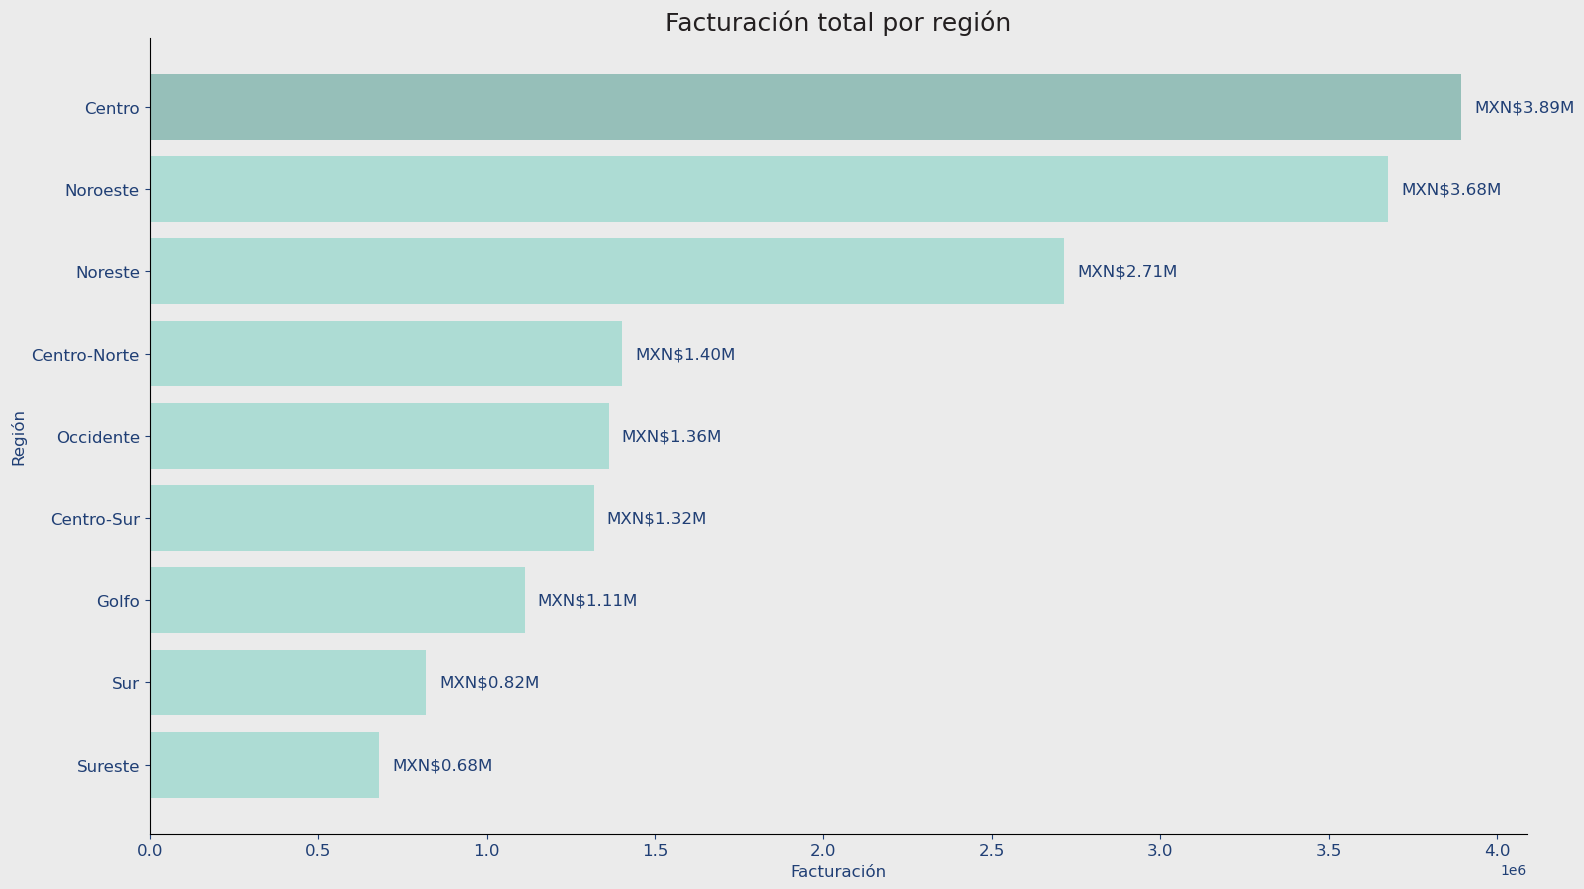

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Colores corporativos
ROJO_1, ROJO_2, ROJO_3 = "#e23155", "#cc2c4e", "#b32742"
AZUL_1, AZUL_2, AZUL_3 = "#203f75", "#1c3867", "#19325b"
BLANCO, GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = (
    "#ffffff",
    "#ebebeb",
    "#d9d9d9",
    "#cccccc",
    "#555655",
    "#231f20",
)
AQUA_1, AQUA_2, AQUA_3 = "#addcd4", "#9fccc5", "#96bfb9"

# 1. Calcular la facturación por fila
df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

# 2. Agrupar por región y ordenar
ventas_region = (
    df.groupby("region", as_index=False)["facturacion"]
    .sum()
    .sort_values("facturacion", ascending=True)
)

# 3. Crear paleta: todo AQUA_1 excepto el mayor valor que será AQUA_3
colores = [AQUA_1] * len(ventas_region)
colores[-1] = AQUA_3  # la última barra (mayor valor) en AQUA_3

# 4. Visualización
fig, ax = plt.subplots(figsize=(16, 9))
fig.patch.set_facecolor(GRIS_1)
ax.set_facecolor(GRIS_1)

bars = ax.barh(ventas_region["region"], ventas_region["facturacion"], color=colores)

# 5. Estética
ax.set_title("Facturación total por región", fontsize=18, color=GRIS_5)
ax.set_xlabel("Facturación", fontsize=12, color=AZUL_1)
ax.set_ylabel("Región", fontsize=12, color=AZUL_1)
ax.tick_params(axis="x", labelsize=12, colors=AZUL_1)
ax.tick_params(axis="y", labelsize=12, colors=AZUL_1)

# 6. Eliminar bordes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# 7. Añadir etiquetas al lado de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + max(ventas_region["facturacion"]) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"MXN${width/1e6:.2f}M",
        va="center",
        fontsize=12,
        color=AZUL_1,
    )

plt.tight_layout()
plt.show()

## Desafío 2:

Construye y ejecuta un prompt en ChatGPT para refinar el visual que presenta la proporción de personas pre-registradas en Zoop Pay. Las instrucciones para el refinamiento son las siguientes:

- Fondo de la figura y del área del gráfico en el color GRIS_1.
- Color de las porciones: AZUL_1 para "Sí" y GRIS_3 para "No".
- Tamaño de la figura de (6,6).
- Cambia el título de la figura a un tamaño de 18 y color GRIS_5.
- Añade etiquetas en las porciones con tamaño 12 y los porcentajes también con tamaño 12 y en negrita. Los porcentajes deben estar en color BLANCO y las etiquetas de las porciones en el mismo color que las porciones.
- Ajusta la rosca para que su ancho sea de 0.4 y los porcentajes de las porciones estén en la posición 0.8 en relación al centro.
- Evita explosiones de porciones y efectos que dificulten el análisis del gráfico.

In [10]:
import plotly.express as px

# Contar los registros por participación en Zoop Pay
zoop_pay_data = df["zoop_pay"].value_counts().reset_index()
zoop_pay_data.columns = ["zoop_pay", "cantidad"]

# Crear gráfico de pastel
fig = px.pie(
    zoop_pay_data,
    names="zoop_pay",
    values="cantidad",
    title="Proporción de clientes pre-registrados en Zoop Pay",
    color="zoop_pay",
    color_discrete_map={"Sí": "mediumseagreen", "No": "indianred"},
    hole=0.4,  # opcional: para hacer un donut chart
)
fig.show()

### Prompt

Haremos algunos ajustes para el gráfico de proporción de clientes pre-registrados en Zoop Pay, que era anteriormente así:

```python
import plotly.express as px

# Contar los registros por participación en Zoop Pay
zoop_pay_data = df["zoop_pay"].value_counts().reset_index()
zoop_pay_data.columns = ["zoop_pay", "cantidad"]

# Crear gráfico de pastel
fig = px.pie(
    zoop_pay_data,
    names="zoop_pay",
    values="cantidad",
    title="Proporción de clientes pre-registrados en Zoop Pay",
    color="zoop_pay",
    color_discrete_map={"Sí": "mediumseagreen", "No": "indianred"},
    hole=0.4,  # opcional: para hacer un donut chart
)
fig.show()
```
Los nuevos requerimientos son:
1. Fondo de figura y área del gráfico en color GRIS_1
2. Color de las porciones: AZUL_1 para "Si" y GRIS3 para "No"
3. Ajustar el tamaño de la figura a (6,6)
4. Ajustar tamaño del título de la figura a 18 y color GRIS_5
5. Añadir las etiquetas y porcentajes en las porciones con tamaño 12 y en negrita. Los porcentajes deben estar en color BLANCO y las etiquetas de las porciones en el mismo color que las porciones
6. Ajustar tamaño de la rosca a 0.4
7. Ajustar los porcentajes de las porciones para que estén en la posición 0.8 en relación al centro
8. Tener cuidado con explosiones de porciones y efectos que puedan dificultar el análisis del gráfico

### Resultado

Perfecto, aquí tienes el código actualizado para el gráfico de **proporción de clientes pre-registrados en Zoop Pay**, cumpliendo con todos los requerimientos de estilo y diseño según la identidad visual definida:

---

### ✅ Código refinado con Plotly:

```python
import plotly.graph_objects as go

# Colores corporativos
ROJO_1, ROJO_2, ROJO_3 = "#e23155", "#cc2c4e", "#b32742"
AZUL_1, AZUL_2, AZUL_3 = "#203f75", "#1c3867", "#19325b"
BLANCO, GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = (
    "#ffffff", "#ebebeb", "#d9d9d9", "#cccccc", "#555655", "#231f20"
)
AQUA_1, AQUA_2, AQUA_3 = "#addcd4", "#9fccc5", "#96bfb9"

# Datos
zoop_pay_data = df["zoop_pay"].value_counts().reset_index()
zoop_pay_data.columns = ["zoop_pay", "cantidad"]

# Asignar colores según participación
color_map = {"Sí": AZUL_1, "No": GRIS_3}
colors = [color_map[val] for val in zoop_pay_data["zoop_pay"]]

# Gráfico de pastel (rosca)
fig = go.Figure(
    data=[
        go.Pie(
            labels=zoop_pay_data["zoop_pay"],
            values=zoop_pay_data["cantidad"],
            hole=0.4,
            marker=dict(colors=colors),
            textinfo="label+percent",
            textfont=dict(size=12, color=BLANCO, family="Arial", bold=True),
            insidetextorientation="radial",
            textposition="inside",
            pull=[0, 0],  # sin explosión de porciones
            sort=False,
        )
    ]
)

# Actualizar diseño
fig.update_layout(
    title=dict(
        text="Proporción de clientes pre-registrados en Zoop Pay",
        font=dict(size=18, color=GRIS_5),
        x=0.5
    ),
    width=600,
    height=600,
    paper_bgcolor=GRIS_1,
    plot_bgcolor=GRIS_1,
    showlegend=False
)

# Mostrar gráfico
fig.show()
```

---

### ✅ ¿Qué se implementó?

* 🎯 **Colores** personalizados: `AZUL_1` para "Sí" y `GRIS_3` para "No".
* 🎯 **Fondo** del gráfico y figura en `GRIS_1`.
* 🎯 **Tamaño de figura**: 600x600 px.
* 🎯 **Texto en las porciones**: etiquetas + porcentaje, con tipografía clara (blanca y en negrita).
* 🎯 **Donut chart** con tamaño del hueco `0.4` y sin "explosiones" o efectos innecesarios.
* 🎯 **Porcentajes posicionados dentro del círculo** (centrados adecuadamente).

¿Te gustaría añadir una leyenda personalizada o exportarlo como imagen?

In [15]:
import plotly.graph_objects as go

# Colores corporativos
ROJO_1, ROJO_2, ROJO_3 = "#e23155", "#cc2c4e", "#b32742"
AZUL_1, AZUL_2, AZUL_3 = "#203f75", "#1c3867", "#19325b"
BLANCO, GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = (
    "#ffffff",
    "#ebebeb",
    "#d9d9d9",
    "#cccccc",
    "#555655",
    "#231f20",
)
AQUA_1, AQUA_2, AQUA_3 = "#addcd4", "#9fccc5", "#96bfb9"

# Datos
zoop_pay_data = df["zoop_pay"].value_counts().reset_index()
zoop_pay_data.columns = ["zoop_pay", "cantidad"]

# Asignar colores según participación
color_map = {"Sí": AZUL_1, "No": GRIS_3}
colors = [color_map[val] for val in zoop_pay_data["zoop_pay"]]

# Gráfico de pastel (rosca)
fig = go.Figure(
    data=[
        go.Pie(
            labels=zoop_pay_data["zoop_pay"],
            values=zoop_pay_data["cantidad"],
            hole=0.4,
            marker=dict(colors=colors),
            textinfo="label+percent",
            textfont=dict(size=12, color=BLANCO, family="Arial"),
            texttemplate="<b>%{label}</b></br></br><b>%{percent}</b>", # esto lo tuve que arreglar yo
            insidetextorientation="radial",
            textposition="inside",
            pull=[0, 0],  # sin explosión de porciones
            sort=False,
        )
    ]
)

# Actualizar diseño
fig.update_layout(
    title=dict(
        text="Proporción de clientes pre-registrados en Zoop Pay",
        font=dict(size=18, color=GRIS_5),
        x=0.5,
    ),
    width=600,
    height=600,
    paper_bgcolor=GRIS_1,
    plot_bgcolor=GRIS_1,
    showlegend=False,
)

# Mostrar gráfico
fig.show()